# Объединение алгоритмов в цепочки и конвейеры

Как мы уже говорили, для многих алгоритмов машинного
обучения очень важное значение имеет определенное преобразование
данных. Оно начинается с масштабирования данных и объединения
признаков вручную, а также включает в себя процесс преобразования
признаков с помощью неконтролируемого обучения. Поэтому большая часть проектов машинного обучения требует
не разового использования какого-то одного алгоритма, а применения
различных операций предварительной обработки и моделей машинного
обучения, объединенных в цепочку. Далее будет рассказано, как
использовать класс Pipeline, чтобы упростить процесс построения
цепочек преобразований и моделей. В частности, мы увидим, как можно
объединить Pipeline и GridSearchCV для поиска параметров по всем
операциям предварительной обработки сразу.
В качестве примера, который подчеркивает важность построения
цепочек моделей, можно привести случай применения ядерного SVM к
набору данных cancer. Значительного улучшения работы модели можно
добиться, использовав MinMaxScaler для предварительной обработки.
Ниже приводится программный код для разбиения данных, вычисления
минимума и максимума, масштабирования данных и построения SVM:

In [113]:
#from preamble import *
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [115]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# загружаем и разбиваем данные
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)
    

# вычисляем минимум и максимум по обучающим данным
scaler = MinMaxScaler().fit(X_train)

In [116]:
scaler.transform(X_train) == MinMaxScaler().fit_transform(X_train)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [54]:
# масштабируем обучающие данные
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# строим SVM на масштабированных обучающих данных
svm.fit(X_train_scaled, y_train)
# scale the test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
print("Правильность на тестовом наборе: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Правильность на тестовом наборе: 0.97


In [55]:
X_test_s = MinMaxScaler().fit_transform(X_test)

In [43]:
print("Правильность на тестовом наборе: {:.2f}".format(svm.score(X_test_s, y_test)))

Правильность на тестовом наборе: 0.97


### Отбор параметров с использованием предварительной обработки 

Теперь предположим, мы хотим найти более оптимальные параметры для
SVC с помощью GridSearchCV. Как нам
выполнить это? Наивный подход может выглядеть следующим образом:

In [56]:
from sklearn.model_selection import GridSearchCV
# только в иллюстративных целях, не используйте этот код!
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Наил знач правильности перекр проверки: {:.2f}".format(grid.best_score_))
print("Наилучшие параметры: ", grid.best_params_)
print("Наилучшее значение правильности на тесте: {:.2f}".format(grid.score(X_test_scaled, y_test)))

Наил знач правильности перекр проверки: 0.98
Наилучшие параметры:  {'C': 1, 'gamma': 1}
Наилучшее значение правильности на тесте: 0.97


Здесь мы запустили решетчатый поиск по параметрам SVC,
использовав масштабированные данные. Однако нюанс заключается в
том, как мы сейчас это сделали. При масштабировании данных мы
использовали все данные обучающего набора, чтобы вычислить
минимальные и максимальные значения признаков. Затем мы
используем масштабированные обучающие данные, чтобы запустить наш
решетчатый поиск с использованием перекрестной проверки. При
каждом разбиении перекрестной проверки определенная часть исходного
обучающего набора становится тренировочными блоками, а другая часть
– проверочным блоком. Проверочный блок используется для оценки
работы обученной модели на новых данных. Однако мы уже
использовали информацию, содержащуюся в проверочном блоке, когда
масштабировали данные. Вспомним, что проверочный блок в каждом
разбиении перекрестной проверки является частью обучающего набора,
а мы использовали информацию всего обучающего набора для поиска
правильного масштаба данных. Мы получим совершенно другое
представление новых данных в модели. Новые данные (скажем,
представленные в виде тестового набора) не будут использованы при
масштабировании обучающих данных и могут иметь значения минимума
и максимума, отличающиеся от значений минимума и максимума для
обучающих данных. Следующий пример (рис.) показывает различие
между обработкой данных в ходе перекрестной проверки и итоговой
оценкой:

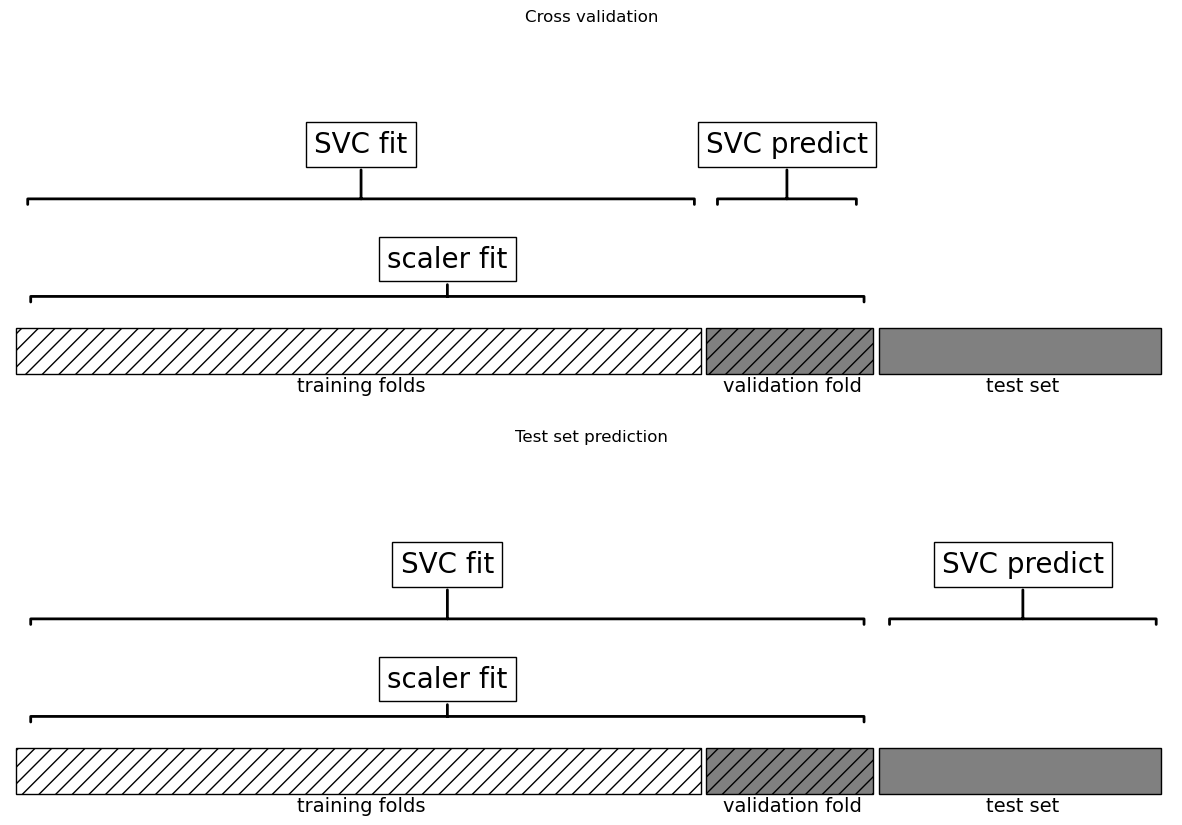

In [57]:
import mglearn
mglearn.plots.plot_improper_processing()

Таким образом, разбиения перекрестной проверки не позволяют
больше адекватно моделировать новые данные. Мы уже «поделились»
информацией, содержащейся в этих блоках, с моделью. Это приведет к
чрезмерно оптимистичным результатам перекрестной проверки, и,
возможно, к выбору субоптимальных параметров.
Чтобы обойти эту проблему, разбиения набора данных во время
перекрестной проверки должны быть выполнены перед предварительной
обработкой данных. Любой процесс, извлекающий знания из данных,
должен осуществляться на обучающей части набора данных, и поэтому
его следует разместить внутри цикла перекрестной проверки.
Для решения этой задачи в библиотеке scikit-learn наряду с
функцией cross_val_score и функцией GridSearchCV мы можем
воспользоваться классом Pipeline. Класс Pipeline позволяет
«склеивать» вместе несколько операций обработки данных в единую
модель scikit-learn. Класс Pipeline предусматривает методы fit,
predict и score и имеет все те же свойства, что и любая модель scikitlearn.
Чаще всего класс Pipeline используется для объединения
операций предварительной обработки (например, масштабирования данных) с моделью контролируемого машинного обучения типа
классификатора.

### Построение конвейеров

Давайте посмотрим, как мы можем использовать класс Pipeline, чтобы
осуществить обучение SVM после масштабирования данных с помощью
MinMaxScaler (на этот раз не будем использовать решетчатый поиск). Во-
первых, мы создаем объект-конвейер, передав ему список необходимых
этапов. Каждый этап представляет собой кортеж, содержащий имя
(любая строка на ваш выбор) и экземпляр модели:

In [61]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

Здесь мы создали два этапа: первый этап, названный "scaler",
является экземпляром MinMaxScaler, а второй, названный "svm", является
экземпляром SVC. Теперь мы можем построить конвейер точно так же,
как и любую другую модель scikit-learn:

In [62]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

В данном случае pipe.fit сначала вызывает метод fit объекта
scaler, преобразует обучающие данные, используя MinMaxScaler, и,
наконец, строит модель SVM на основе масштабированных данных.
Чтобы оценить правильность модели на тестовых данных, мы просто
вызываем pipe.score:

In [63]:
print("Правильность на тестовом наборе: {:.2f}".format(pipe.score(X_test, y_test)))

Правильность на тестовом наборе: 0.97


Когда мы вызываем pipe.score, сначала тестовые данные
масштабируются с помощью MinMaxScaler, затем к масштабированным
тестовым данным применяется построенная модель SVM (происходит
вызов метода score объекта svm). Видно, что приведенный вывод
идентичен результату, который мы получили, использовав программный
код в начале главы, когда выполняли преобразования вручную. С
помощью конвейера мы сократили программный код, необходимый для
нашего процесса «предварительная обработка + классификация». Однако
главное преимущество конвейера заключается в том, что сейчас мы
можем использовать эту отдельную модель в качестве аргумента
функции cross_val_score или GridSearchCV.

### Использование конвейера, помещенного в объект GridSearchCV

Использование конвейера в объекте GridSearchCV аналогично
использованию любой другой модели. Мы задаем сетку параметров для
поиска и строим GridSearchCV на основе конвейера и сетки параметров.
Однако теперь определение сетки параметров выглядит несколько иначе.
Для каждого параметра нам нужно указать этап конвейера, к которому
он относится. Оба параметра, которые мы хотим скорректировать, C и
gamma являются параметрами SVC, то есть относятся ко второму этапу.
Мы назвали этот этап "svm". Синтаксис, позволяющий настроить сетку
параметров для конвейера, заключается в том, чтобы для каждого
параметра указать имя этапа, затем символ двойного подчеркивания,
а потом имя параметра. Чтобы выполнить поиск по параметру C для SVC,
мы в качестве ключа (сетка параметров представляет собой словарь)
должны задать "svm__C", затем ту же самую процедуру нужно выполнить
для gamma:

In [29]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

Задав сетку параметров, мы можем использовать GridSearchCV
обычным образом:

In [30]:
X_test_valid, X_test, y_test_valid, y_test = train_test_split(
    X_test, y_test, random_state=0)


In [31]:
ggrid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Наил значение правильности перекр проверки: {:.2f}".format(grid.best_score_))
print("Правильность на тестовом наборе: {:.2f}".format(grid.score(X_test_valid, y_test_valid)))
print("Наилучшие параметры: {}".format(grid.best_params_))

Наил значение правильности перекр проверки: 0.92
Правильность на тестовом наборе: 0.93
Наилучшие параметры: {'C': 1, 'gamma': 0.001}


In [64]:
print("Правильность на тестовом наборе: {:.2f}".format(grid.score(X_test, y_test)))

Правильность на тестовом наборе: 0.37


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]})

В отличие от решетчатого поиска, выполненного ранее, теперь для
каждого разбиения перекрестной проверки MinMaxScaler выполняет
масштабирование данных, используя лишь обучающие блоки разбиений,
и теперь информация тестового блока не передается модели при поиске
параметров. Сравните выполнение перекрестной проверки и итоговой
оценки теперь (рис.) и ранее (рис.):

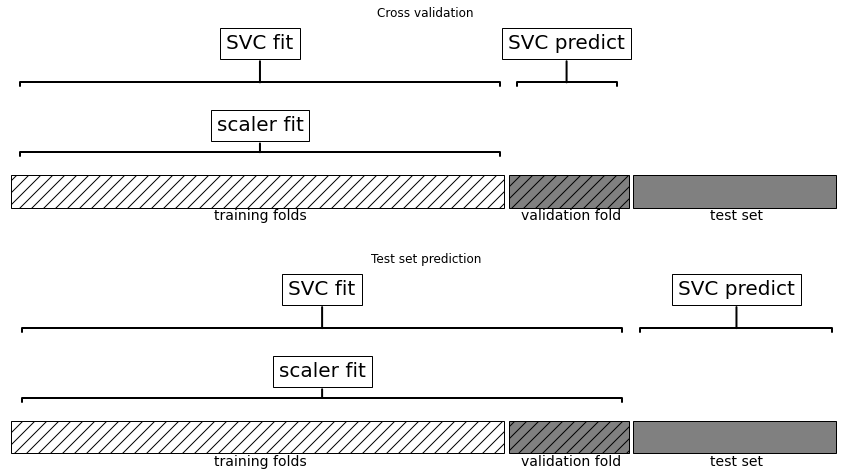

In [33]:
mglearn.plots.plot_proper_processing()

Последствия утечки информации, возникающей в ходе перекрестной
проверки, обусловлены характером предварительной обработки.
Масштабирование данных с использованием проверочного блока, как
правило, не имеет серьезных последствий, в то время как использование
проверочного блока для выделения и отбора признаков может привести
к существенно различающимся результатам.

Утечка информации см. блокнот <b>Lesson24 inf</b>

### Общий интерфейс конвейера

Класс Pipeline не ограничивается предварительной обработкой и
классификацией, с его помощью можно объединить любое количество
моделей. Например, можно создать конвейер, включающий в себя
выделение признаков, отбор признаков, масштабирование и
классификацию, в общей сложности четыре этапа. Кроме того,
последним этапом вместо классификации может быть регрессия или
кластеризация.
Единственное требование, предъявляемое к моделям в конвейере,
заключается в том, что все этапы, кроме последнего, должны
использовать метод transform, таким образом, они позволяют
сгенерировать новое представление данных, которое можно использовать
на следующем этапе.
Во время вызова Pipeline.fit конвейер поочередно вызывает метод
fit, а затем метод transform каждого этапа, вводная информация
представляет собой вывод метода transform для предыдущего этапа. Для
последнего этапа конвейера просто вызывается метод fit.
Опустив некоторые мелкие детали, все вышесказанное можно
реализовать с помощью программного кода, приведенного ниже. Следует
помнить, что pipeline.steps является списком кортежей, поэтому
pipeline.steps [0][1] является первой моделью, а line.steps[1][1] –
второй моделью и так далее:

In [11]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # перебираем все этапы, кроме последнего
        # подгоняем и преобразуем данные
        X_transformed = estimator.fit_transform(X_transformed, y)
    # осуществляем подгонку на последнем этапе
    self.steps[-1][1].fit(X_transformed, y)
    return self

При прогнозировании с помощью конвейера мы одинаковым образом
преобразуем данные на всех этапах, кроме последнего, а затем вызываем
метод predict на последнем этапе:

In [35]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # перебираем все этапы, кроме последнего
        # преобразуем данные
        X_transformed = step[1].transform(X_transformed)
    # получаем прогнозы на последнем этапе
    return self.steps[-1][1].predict(X_transformed)

На рис. проиллюстрирован конвейер, включающий два
модификатора T1 и T2 и классификатор (Classifier).

![pipeline_illustration](images/pipeline.png)

На самом деле конвейер может иметь более общий вид.
Использование predict на последнем этапе конвейера не является
обязательным требованием и мы могли бы создать конвейер, который
содержит scaler и PCA. Затем, поскольку последний шаг (PCA) использует
метод transform, мы могли бы вызвать метод transform конвейера, чтобы
получить вывод PCA.transform, примененный к данным, которые были
обработаны на предыдущем этапе. Последний этап конвейера требуется
только для применения метода fit.

# Удобный способ построения конвейеров с помощью функции ``make_pipeline``

Построение конвейера с помощью вышеописанного синтаксиса иногда
выглядит немного громоздким и, как правило, нам нет необходимости
присваивать имя каждому этапу. Существует удобная функция
make_pipeline, которая позволяет создать конвейер и автоматически
присвоить имя каждому этапу, исходя из его класса (напомним, что
каждый этап представляет собой кортеж, содержащий имя и экземпляр
модели). Синтаксис make_pipeline выглядит следующим образом:

In [65]:
from sklearn.pipeline import make_pipeline
# стандартный синтаксис
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# сокращенный синтаксис
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

Объекты-конвейеры pipe_long и pipe_short выполняют одну и ту же
последовательность операций, но в случае с pipe_short имена этапов
присваиваются автоматически. Мы можем взглянуть на имена этапов с
помощью атрибута steps:

In [66]:
print("Этапы конвейера:\n{}".format(pipe_short.steps))

Этапы конвейера:
[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


Этапам присвоены имена minmaxscaler и SVC. В общем, имена этапов
– это просто названия классов, написанные строчными буквами. Если
несколько этапов используют один и тот же класс, добавляется номер:

In [67]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("Pipeline steps:\n{}".format(pipe.steps))

Pipeline steps:
[('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


Видно, что первый этап StandardScaler был назван standardscaler-1,
а второй – standardscaler-2. Однако в данной ситуации было бы лучше
использовать архитектуру конвейера с явными именами, чтобы
присвоить этапам более содержательные названия.

#### Работа с атрибутами этапов

Часто бывают ситуации, когда вам нужно посмотреть атрибуты одного
из этапов конвейера, например, коэффициенты линейной модели или
компоненты, извлекаемые с помощью PCA. Самый простой способ получить подробную информацию об этапах конвейера заключается в
том, чтобы воспользоваться атрибутом named_steps, который является
словарем с именами этапов и моделями:

In [68]:
# подгоняем заранее заданный конвейер к набору данных cancer
pipe.fit(cancer.data)
# извлекаем первые две главные компоненты на этапе "pca"
components = pipe.named_steps["pca"].components_
print("форма components: {}".format(components.shape))

форма components: (2, 30)


#### Работа с атрибутами конверйера, помещенного в объект GridSearchCV

Как мы уже говорили ранее в этой главе, одна из главных причин
использования конвейеров – это выполнение решетчатого поиска.
Общераспространенная задача – получить доступ к некоторым этапам
конвейера внутри объекта GridSearchCV. Давайте запустим решетчатый
поиск для классификатора LogisticRegression на наборе данных cancer,
использовав Pipeline и StandardScaler, чтобы отмасштабировать данные
перед тем, как передать их в классификатор LogistiсRegression. Сначала
мы создаем конвейер с помощью функции make_pipeline:

In [69]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression())

Далее мы создаем сетку параметров. Как объяснялось в главе 2,
параметр регуляризации С позволяет настроить модель логистической
регрессии (класс LogisticRegression). Мы используем
логарифмическую сетку для этого параметра, поиск осуществляется в
диапазоне значений от 0.01 до 100. Поскольку мы использовали функцию
make_pipeline, имя этапа LogisticRegression записывается в нижнем
регистре как logisticregression. Чтобы настроить параметр C, мы
должны задать сетку параметров в виде logisticregression__C:

In [75]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

И как обычно мы разбиваем набор данных cancer на обучающий и
тестовый наборы и запускаем решетчатый поиск:

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

Итак, каким образом мы можем посмотреть коэффициенты
наилучшей модели логистической регрессии, которые были найдены с
помощью GridSearchCV? Ранее мы узнали, что наилучшая модель,
найденная с помощью GridSearchCV и построенная на всех обучающих
данных, хранится в grid.best_estimator_:

In [78]:
print("Лучшая модель:\n{}".format(grid.best_estimator_))

Лучшая модель:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1))])


В нашем случае наилучшей моделью (best_estimator_) является
конвейер, состоящий из двух этапов standardscaler и
logisticregression. Как уже говорилось ранее, получить информацию
об этапе logisticregression мы можем с помощью атрибута конвейера
named_steps:

In [79]:
print("Этап логистической регрессии:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"]))

Этап логистической регрессии:
LogisticRegression(C=1)


Теперь, когда мы построили логистическую регрессию, можно
взглянуть на регрессионные коэффициенты (веса), связанные с
входными признаками:

In [80]:
print("Коэффициенты логистической регрессии:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"].coef_))

Коэффициенты логистической регрессии:
[[-0.43570655 -0.34266946 -0.40809443 -0.5344574  -0.14971847  0.61034122
  -0.72634347 -0.78538827  0.03886087  0.27497198 -1.29780109  0.04926005
  -0.67336941 -0.93447426 -0.13939555  0.45032641 -0.13009864 -0.10144273
   0.43432027  0.71596578 -1.09068862 -1.09463976 -0.85183755 -1.06406198
  -0.74316099  0.07252425 -0.82323903 -0.65321239 -0.64379499 -0.42026013]]


В результате мы получим довольное длинное регрессионное
уравнение, но оно полезно для понимания модели.

### Находим оптимальные параметры этапов конвейера с помощью решетчатого поиска

С помощью конвейеров мы можем инкапсулировать все этапы
предварительной обработки в одной модели scikit-learn. Еще одно
преимущество конвейеров заключается в том, что теперь мы можем
настроить параметры предварительной обработки , используя результат,
полученный с помощью модели контролируемого машинного обучения
(то есть результат решения регрессионной или классификационной
задачи). При работе с набором данных boston мы перед применением
гребневой регрессии создали полиномиальные признаки. Теперь давайте
используем конвейер. Конвейер включает три этапа – масштабирование
данных, вычисление полиномиальных признаков и построение гребневой
регрессии:

In [82]:
from sklearn.datasets import load_boston
from sklearn.linear_model import Ridge
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

Как мы узнаем, какие степени полиномов нужно выбрать, выбирать
ли полиномы или взаимодействия вообще? В идеале мы хотим выбрать
значение параметра degree, основываясь на результатах классификации.
С помощью нашего конвейера мы можем осуществить поиск значений
параметра degree для полиномиальных преобразований значениями
одновременно с поиском значений параметра alpha модели гребневой
регрессии. Для этого мы задаем сетку параметров в необходимом
формате: после каждого имени этапа следует двойной символ
подчеркивания и соответствующий параметр:

In [83]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [88]:
import numpy as np
np.linspace(12,18,7)

array([12., 13., 14., 15., 16., 17., 18.])

In [89]:
param_grid = {'polynomialfeatures__degree': [1,2,3],
              'ridge__alpha': np.linspace(13,18,6)}

Теперь мы можем запустить наш решетчатый поиск снова:

In [90]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': array([13., 14., 15., 16., 17., 18.])})

Результат перекрестной проверки можно визуализировать с помощью
теплокарты (рис.), как мы уже делали ранее:

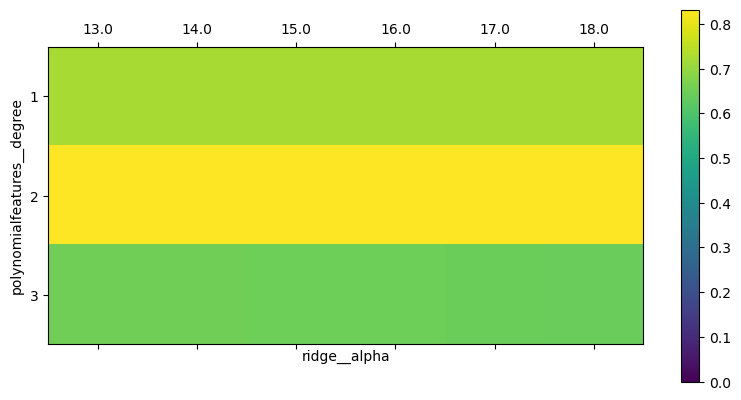

In [91]:
import matplotlib.pyplot as plt
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1),
           vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),
          param_grid['polynomialfeatures__degree'])

plt.colorbar()

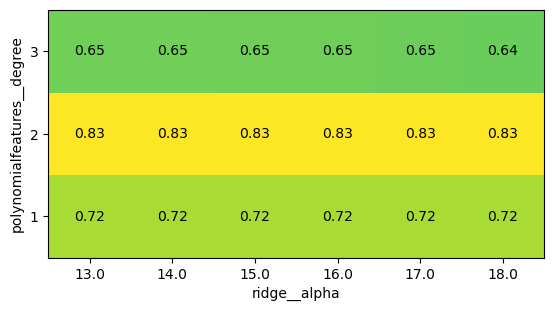

In [92]:
import mglearn
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3, -1),
                      xlabel="ridge__alpha", ylabel="polynomialfeatures__degree",
                      xticklabels=param_grid['ridge__alpha'],
                      yticklabels=param_grid['polynomialfeatures__degree'], vmin=0)

In [93]:
grid.cv_results_['mean_test_score'].reshape(3, -1)

array([[0.72326731, 0.72322426, 0.7231715 , 0.72310999, 0.72304056,
        0.72296391],
       [0.83093741, 0.83144099, 0.83185472, 0.83219011, 0.83245664,
        0.83266222],
       [0.65341751, 0.65232984, 0.65048684, 0.64813136, 0.64544644,
        0.64256995]])

Взглянув на результаты, полученные с помощью перекрестной
проверки, мы можем увидеть, что степень полинома 2 помогает, однако
степень полинома 3 дает гораздо худший результат, чем степень 1 или
степень 2. Данный факт отражается в найденных наилучших параметрах:

In [94]:
print("Наилучшие парметры: {}".format(grid.best_params_))

Наилучшие парметры: {'polynomialfeatures__degree': 2, 'ridge__alpha': 18.0}


которые дают следующее значение правильности:

In [95]:
print("Правильность на тестовом наборе: {:.2f}".format(grid.score(X_test, y_test)))

Правильность на тестовом наборе: 0.78


Давайте для сравнения запустим решетчатый поиск без
полиномиального преобразования:

In [96]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Правильность без полином. преобразования: {:.2f}".format(grid.score(X_test, y_test)))

Правильность без полином. преобразования: 0.63


Как мы и предполагали, анализируя результаты решетчатого поиска,
приведенные на рис., отказ от использования полиномиальных
признаков привел к существенно худшим результатам.
Одновременный поиск параметров предварительной обработки и
параметров модели является очень мощной стратегией. Однако имейте в
виду, что GridSearchCV перебирает все возможные комбинации заданных
параметров. Поэтому включение в сетку большего количества
параметров ведет к экспоненциальному росту моделей.

##### Выбор оптимальной модели с помощью решетчатого поиска

Вы можете пойти дальше, объединив GridSearchCV и Pipeline: можно
осуществлять поиск лишь по фактическим этапам, выполняемым в
конвейере (например, речь может идти о целесообразности
использования StandardScaler или MinMaxScaler). Подобное действие
приведет к еще большему пространству поиска и нужно тщательно
взвесить его целесообразность. Как правило, перебор всех возможных
моделей не является оптимальной стратегией машинного обучения.
Однако ниже приводится пример сравнения результатов работы
RandomForestClassifier и SVC на наборе данных iris. Мы знаем, что SVC,
возможно, потребуются отмасштабированные данные, поэтому
необходимо решить, использовать StandardScaler или обойтись без
предварительной обработки. Что касается RandomForestClassifier, мы
знаем, что для него предварительная обработка данных не требуется. Мы
начинаем с построения конвейера. В данном случае мы задаем имена
этапов в явном виде. Наш конвейер будет включать два этапа: один – для
предварительной обработки, второй – для классификатора. Создаем
экземпляры объектов с помощью SVC и StandardScaler:

In [97]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

Теперь мы можем задать сетку параметров для поиска. Нам нужно
выбрать либо RandomForestClassifier, либо SVC. Поскольку они
используют разные параметры для настройки, один метод нуждается в
предварительной обработке, а другой – нет, мы можем воспользоваться
списком словарей, в котором каждый словарь представляет отдельную
сетку параметров (см. раздел «Экономичный решетчатый поиск»). Чтобы
задать модель для этапа, мы должны указать имя этапа в качестве
названия параметра. Если нам нужно пропустить какой-то этап в
конвейере (например, потому что нам не нужна предварительная
обработка для RandomForest), мы можем задать для этапа значение None:

In [100]:
np.linspace(1,5,5)

array([1., 2., 3., 4., 5.])

In [103]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [ExtraTreesClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3,5,9]},
     {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': np.linspace(1,5,5) }]

Мы можем создать экземпляр класса GridSearchCV и запустить
решетчатый поиск в обычном режиме на наборе данных cancer.

In [118]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

X_train_valid, X_test_valid, y_train_valid, y_test_valid = train_test_split(
    X_test, y_test, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Наилучшие параметры:\n{}\n".format(grid.best_params_))
print("Наилучшиее значение правильности перекрестной проверки: {:.2f}".format(grid.best_score_))
print("Правильность на тестовом наборе: {:.2f}".format(grid.score(X_train_valid, y_train_valid)))

Наилучшие параметры:
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

Наилучшиее значение правильности перекрестной проверки: 0.99
Правильность на тестовом наборе: 0.98


In [120]:
print("Правильность на тестовом наборе: {:.2f}".format(grid.score(X_test_valid, y_test_valid)))

Правильность на тестовом наборе: 0.97


По итогам решатчатого поиска становится ясно, что модель SVC с
предварительной обработкой StandardScaler, параметрами C=10 и
gamma=0.01 дает наилучший результат.

#### Как избежать избыточных вычислений

In [51]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())],
                memory="cache_folder")

### Выводы
Сейчас мы рассказали о классе Pipeline, инструменте,
позволяющем объединять в одну цепочку несколько этапов
предварительной обработки. В реальности проекты машинного обучения
редко состоят из одной лишь модели, чаще всего они представляют собой
последовательность этапов предварительной обработки. Конвейеры
позволяет инкапсулировать несколько этапов в один питоновский
объект, который поддерживает уже знакомый интерфейс scikit-learn,
предлагая воспользоваться методами fit, predict, transform. Если
говорить более конкретно, применение класса Pipeline, охватывающего
все этапы предварительной обработки, важно для правильной оценки
качества модели. Кроме того, класс Pipeline позволяет писать более
лаконичный код и уменьшает вероятность ошибок, которые могут быть
допущены при построении цепочек операций без использования класса
pipeline (например, мы можем забыть применить все преобразования к
тестовому набору или можем применить их в неправильном порядке).
Выбор оптимального сочетания извлеченных признаков, стратегии
предварительной обработки, а также модели – это в определенной
степени искусство, овладеть которым можно методом проб и ошибок.
Однако использование конвейеров довольно существенно облегчает
«экспериментирование» с различными операциями предварительной
обработки данных. При проведении экспериментов постарайтесь не
слишком усложнять процессы подготовки данных и убедитесь в том, что
каждый оцениваемый компонент, включенный в ваш конвейер, является
необходимым этапом.
Этим мы завершаем наш обзор инструментов и алгоритмов
библиотеки scikit-learn. Теперь вы обладаете всеми необходимыми
навыками и знакомы с механизмами применения машинного обучения
на практике. 